In [62]:
import zipfile
import os
import preprocessing as ppg
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from random import randint
from catboost import CatBoostClassifier

pd.options.mode.chained_assignment = None

# Распаковка

In [2]:
def unpack_data(zip_file: str, data_list: list) -> None:
    with zipfile.ZipFile(f'{zip_file}.zip', 'r') as zipFile:
        zipFile.extractall()
    for mode in data_list:
        dealsList = os.listdir(f'data/{mode}/{mode}_deals')
        for deals in dealsList:
            with zipfile.ZipFile(f'data/{mode}/{mode}_deals/{deals}', 'r') as zipFile:
                zipFile.extractall(f'data/{mode}/{mode}_deals')
            os.remove(f'data/{mode}/{mode}_deals/{deals}')
    return None

In [3]:
# В каких папках распаковать deals
DATA_LIST = ['train', 'test']

In [4]:
unpack_data('data', DATA_LIST)

# Препроцессинг

In [5]:
ppg.format_main('train', True)
ppg.format_main('test', False)

In [6]:
for mode in ['train', 'test']:
    path = f'data/{mode}/{mode}.csv'
    main = pd.read_csv(path, sep = ',')
    ids = main['id']
    for id in ids:
        ppg.format_account_condition(id, mode)
        ppg.format_reference_point(id, mode)
        for i in range(1, 4):
            ppg.format_deals(id, i, mode)

c:\Users\fromf\OneDrive\Документы\Git Repositories\Stonks_Project\preprocessing.py:70: RuntimeWarning: invalid value encountered in scalar divide
  volatility = (abs((final_price - start_price))/start_price) * 100
c:\Users\fromf\OneDrive\Документы\Git Repositories\Stonks_Project\preprocessing.py:70: RuntimeWarning: invalid value encountered in scalar divide
  volatility = (abs((final_price - start_price))/start_price) * 100
c:\Users\fromf\OneDrive\Документы\Git Repositories\Stonks_Project\preprocessing.py:70: RuntimeWarning: invalid value encountered in scalar divide
  volatility = (abs((final_price - start_price))/start_price) * 100
c:\Users\fromf\OneDrive\Документы\Git Repositories\Stonks_Project\preprocessing.py:70: RuntimeWarning: invalid value encountered in scalar divide
  volatility = (abs((final_price - start_price))/start_price) * 100
c:\Users\fromf\OneDrive\Документы\Git Repositories\Stonks_Project\preprocessing.py:70: RuntimeWarning: invalid value encountered in scalar divid

# Чтение и обработка данных

In [7]:
def additional_data_to_dict(mode: str, main_df: pd.DataFrame) -> dict:
    data = dict()
    ids = main_df.id
    for id in ids:
        acc_conf = f'data/{mode}/{mode}_additional_info/id_{id}/account_condition_{id}.csv'
        ref_point = f'data/{mode}/{mode}_additional_info/id_{id}/reference_point_{id}.csv'
        stat_table = f'data/{mode}/{mode}_additional_info/id_{id}/stats_table_{id}.csv'
        deals_1 = f'data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'data/{mode}/{mode}_deals/3_{id}.csv'
        data[id] = {
                  'account_condition': pd.read_csv(acc_conf) if os.path.exists(acc_conf) else None, 
                  'reference_point': pd.read_csv(ref_point) if os.path.exists(ref_point) else None, 
                  'stats_table': pd.read_csv(stat_table, sep=';') if os.path.exists(stat_table) else None,
                  'deals': pd.read_csv(deals_1) if os.path.exists(deals_1) 
                                else pd.read_csv(deals_2) if os.path.exists(deals_2)
                                else pd.read_csv(deals_3) if os.path.exists(deals_3)
                                else None
                }
    return data

In [8]:
def drop_outlier(df: pd.DataFrame, lower_quantile: float, upper_quantile: float):
    columns = ['start_sum', 'income_percent', 'deals']

    # Словари для хранения нижних и верхних границ для каждого столбца
    lower_bounds = {}
    upper_bounds = {}

    # Вычисление нижних и верхних границ для каждого столбца
    for col in columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        lower_bounds[col] = lower_bound
        upper_bounds[col] = upper_bound

    # Создаем фильтр для удаления выбросов по вычисленным границам
    mask = pd.Series(True, index=df.index)
    for col in columns:
        mask = mask & (df[col] >= lower_bounds[col]) & (df[col] <= upper_bounds[col])

    # Применяем фильтр к датафрейму
    df_filtered = df[mask]
    df = df_filtered
    return df

In [30]:
# Cловарm с таблицами всех юзеров из трейна и из теста
train = pd.read_csv('data/train/train.csv', sep = ',').drop(columns = 'broker')
train = drop_outlier(train, 0.1, 0.8)
train['income_percent'].fillna(train.income_rub/train.start_sum, inplace = True)

test = pd.read_csv('data/test/test.csv', sep = ',').drop(columns = 'broker')

In [31]:
# Cловарm с таблицами всех юзеров из трейна и из теста
data = dict()

data.update(additional_data_to_dict('train', train))
data.update(additional_data_to_dict('test', test))

# Feature engineering

In [32]:
def adding_deal_sum_info(df: pd.DataFrame) -> pd.DataFrame:
    df['mean_deal_sum'] = 0
    df['std_deal_sum'] = 0
    df['len_deals'] = 0
    for id in df.id:
        table = data[id]['deals']
        if table is not None:
            df.mean_deal_sum.loc[df.id == id] = table.summ.mean()
            std = table.summ.std()
            df.std_deal_sum.loc[df.id == id] = std if not np.isnan(std) else 0
            df.len_deals.loc[df.id == id] = len(table)

    non_zero_rows = df[df['mean_deal_sum'] != 0].drop(columns = ["nickname", "id", "std_deal_sum", "class"])
    lin_reg = LinearRegression()
    lin_reg.fit(non_zero_rows.drop(columns = ['mean_deal_sum']), non_zero_rows['mean_deal_sum'])
    zero_rows = df[df['mean_deal_sum'] == 0].drop(columns = ["nickname", "id", "std_deal_sum", "class"])
    predicted_values = lin_reg.predict(zero_rows.drop(columns = ['mean_deal_sum']))
    df.loc[df['mean_deal_sum'] == 0, 'mean_deal_sum'] = predicted_values
    
    non_zero_rows = df[df['std_deal_sum'] != 0].drop(columns = ["nickname", "id", "class"])
    lin_reg = LinearRegression()
    lin_reg.fit(non_zero_rows.drop(columns = ['std_deal_sum']), non_zero_rows['std_deal_sum'])
    zero_rows = df[df['std_deal_sum'] == 0].drop(columns = ["nickname", "id", "class"])
    predicted_values = lin_reg.predict(zero_rows.drop(columns = ['std_deal_sum']))
    df.loc[df['std_deal_sum'] == 0, 'std_deal_sum'] = predicted_values
    
    return df

In [33]:
def adding_frequent_market_info(df: pd.DataFrame) -> pd.DataFrame:
    df['stock_coef'] = 0
    df['curr_coef'] = 0
    df['fort_coef'] = 0
    df['freq_market'] = 0
    
    df['income_percent_stats'] = 0 
    
    for id in df.id:
        table = data[id]['stats_table']
        if table is not None:
            
            # market coefs
            stock_turnover = table.loc[1, 'part_turnover'] if table.loc[1, 'part_turnover'] != '-' else 0
            curr_turnover = table.loc[3, 'part_turnover']  if table.loc[3, 'part_turnover'] != '-' else 0
            fort_turnover = table.loc[2, 'part_turnover']  if table.loc[2, 'part_turnover'] != '-' else 0
            
            df.stock_coef.loc[df.id == id] = float(stock_turnover) 
            df.curr_coef.loc[df.id == id] = float(curr_turnover) 
            df.fort_coef.loc[df.id == id] = float(fort_turnover) 
            
            df.freq_market.loc[df.id == id] = \
                        max(enumerate([0, float(stock_turnover), float(curr_turnover), float(fort_turnover)]),key=lambda x: x[1])[0]
                            
            # income 
            df.income_percent_stats.loc[df.id == id] = table.loc[0, "income_percent"]
    
    return df.fillna(0)



In [34]:
def adding_free_funds_info(df: pd.DataFrame) -> pd.DataFrame:
    df['std_free_funds'] = 0
    df['coef_free_funds'] = 0
    df['coef_free_funds2'] = 0
    df['mean_free_funds'] = 0
    df['min_free_funds'] = 0
    df['max_free_funds'] = 0
    
    for id in df.id:
        table = data[id]['account_condition']
        if table is not None:
            std = (table.free_funds).std()
            df.std_free_funds.loc[df.id == id] = std
            
            if len(table)<1:
                df.coef_free_funds.loc[df.id == id] = 0
                df.coef_free_funds2.loc[df.id == id] = 0
            else:
                df.coef_free_funds.loc[df.id == id] = \
                                    std / table.start_sum.iloc[0]
                df.coef_free_funds2.loc[df.id == id] = \
                                    (std / table.start_sum.iloc[0])**2
            
            df.mean_free_funds.loc[df.id == id] = np.mean(table.free_funds)
            df.max_free_funds.loc[df.id == id] = np.max(table.free_funds)
            df.min_free_funds.loc[df.id == id] = np.min(table.free_funds)
            
    
    return df

In [35]:
def adding_features(df: pd.DataFrame) -> pd.DataFrame:
    df = adding_deal_sum_info(df)
    df = adding_frequent_market_info(df)
    df = adding_free_funds_info(df)
    return df

In [36]:
train = adding_features(train)

# Embeddings

In [37]:
def random_embedding(vec, fix_size):
    emb = [vec[randint(0, len(vec)-1)] for _ in range(fix_size)]
    return emb

In [38]:
def sort_dist_embedding(vec, fix_size):
    '''
    making a fix_size embedding by selecting far values after vector sorting
    
    parameters: vec - pca vector, fix_size - size for embedding
    returns: emb - fix_size embedding
    '''
    
    emb = [sorted(vec)[i*(len(vec)//(fix_size-1)) if i!=fix_size-1 else -1] for i in range(fix_size)]
    return emb

In [39]:
def distribution_discription_embedding(vec):
    emb = [np.mean(vec), np.std(vec), pd.Series(vec).skew(), pd.Series(vec).kurt()]
    return emb

In [40]:
def approximation_embedding(vec, fix_size):
    emb = [ np.mean( sorted(vec)[(i-1)*(len(vec)//(fix_size-1)) : (i*(len(vec)//(fix_size-1)) \
                                                                 if i!=fix_size-1 else -1)] )  \
                                                                 for i in range(1, fix_size+1) ]

    emb = [i if not np.isnan(i) else 0 for i in emb]
    return emb

In [41]:
def adding_embeddings(dataset, fix_size = 5):
    '''
    adding embedding of additional tables to main dataframe
    
    parameters: dataset - pd.DataFrame (dataset for adding features)
    returns: dataset - pd.DataFrame (dataset with new columns)
    '''
    
    for i in range(fix_size):
        dataset[f"emb{i}"] = 0
        
    for id in dataset.id:
        table = data[id]['deals']
        
        if table is not None:
            
            # prepro
            table = table.drop(columns = ["Unnamed: 0", "ticker"])
            table['datetime'] = pd.to_datetime(table['datetime'])
            table['datetime'] = table['datetime'].apply(lambda x: x.timestamp())

            # PCA vector 
            pca = PCA(n_components=1)
            scaler = StandardScaler().fit_transform(table)
            vec = pca.fit_transform(scaler)
            vec = [i[0] for i in vec]
            
            # embs
            emb = approximation_embedding(vec, fix_size)
            
            # adding emb to dataset 
            dataset.loc[dataset.id==id, "emb0":f"emb{fix_size-1}"] = emb

    return dataset
    


In [42]:
train = adding_embeddings(train, 18)

c:\Users\fromf\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fromf\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\fromf\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fromf\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\fromf\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fromf\AppData\Loca

# Соединение таблиц

In [43]:
id_len = {id: len(data[id]['deals'] if data[id]['deals'] is not None else []) for id in train.id}

In [44]:
def concat_deals(dataset):
    for id in dataset.id:
        table = data[id]['deals']
        if table is not None:
            data[id]['deals']["id"] = id
    return pd.concat([ data[id]['deals'] for id in dataset.id ], ignore_index=True)


In [45]:
train = pd.merge(concat_deals(train), train, on ='id') # по id соединяем юзера с его deals 

In [46]:
def my_train_test_split(df, random_state=42, train_size = 0.75):
    
    X_train, X_test = pd.DataFrame(columns = df.columns), pd.DataFrame(columns = df.columns)
    y_train, y_test = pd.Series([]), pd.Series([])
    
    while (len(X_train) / len(df)) < (train_size / (1-train_size)):
        unique_ids = df.id.unique() 
        rand_id = unique_ids[randint(0, len(unique_ids)-1)] # рандомный id юзера
        X_train = pd.concat([X_train, df[df.id==rand_id]], ignore_index=True) # добавляем в треин выборку операции этого юзера
        y_train = y_train + pd.Series([df[df.id == rand_id]['class'].values[0]] * id_len[rand_id])
        df.drop(df[df.id == rand_id].index, inplace = True) # удаляем операции юзера из датафрейма, который потом станет тестовым
    X_test = df.drop(columns = ["class", "nickname"])
    X_train = X_train.drop(columns = ["class", "nickname"])
    X_test = X_test[X_train.columns]
    y_test = df['class']
    return X_train, X_test, y_train, y_test

In [47]:
#X_train, X_test, y_train, y_test = my_train_test_split(train, train_size = 0.75)

# Обучение моделей

In [49]:
# splitting train on train and test sets
X = train.drop(columns = ["class", "nickname", "id"])
y = train["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.75)

СatBoostСlassifier 

In [50]:
%%time

cat_columns = X_train.select_dtypes(include=['object']).columns
model = CatBoostClassifier(cat_features = [cat_columns[0]], verbose=0, loss_function='MultiClass')

param_grid = {'iterations': [500, 1000, 300],
              'learning_rate': [0.05, 0.1, 0.2],
              'depth': [4, 5],
              "l2_leaf_reg": [4, 10, 20]}

grid_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid, 
                                 cv=5, 
                                 scoring='f1_macro', 
                                 error_score='raise', 
                                 n_iter=6)

grid_search.fit(X_train, y_train, cat_features = [cat_columns[0]])

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.2, 'l2_leaf_reg': 10, 'iterations': 300, 'depth': 5}
Best CV Score: 0.9991378290990152
CPU times: total: 23min 1s
Wall time: 20min 7s


In [51]:
results = grid_search.cv_results_
print("Results of all configurations", results['mean_test_score'])

Results of all configurations [0.98908281 0.99913783 0.992028   0.99781049 0.98334865 0.98214819]


Метрики

In [52]:
def metrics(y_true, y_pred):
    '''
    calculation of metrics f1-score and RMSE
    
    parameters: y_true - series of right classes, y_pred - series of predicted classes
    returns: rmse, f1 - tuple of metrics
    '''
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred, average = 'micro')
    return rmse, f1

In [53]:
cbc = grid_search.best_estimator_
y_pred_ts = cbc.predict(X_test)
y_pred_tr = cbc.predict(X_train)

In [56]:
metrics_tr = metrics(y_train, y_pred_tr)
metrics_ts = metrics(y_test, y_pred_ts)

print(f"TRAIN: \nrmse:{metrics_tr[0]}\nf1: {metrics_tr[1]}\nTEST: \nrmse:{metrics_ts[0]}\nf1: {metrics_ts[1]}")


TRAIN: 
rmse:0.022935264313672824
f1: 0.9997489419697295
TEST: 
rmse:0.024933260988622558
f1: 0.9996174353824451


In [57]:
for i, k in zip(cbc.get_feature_importance(), X_train.columns):
    print(i, k)

0.0 Unnamed: 0_x
1.2625441958620922 datetime
0.025657991410649592 ticker
0.0 quantity
0.05423733929878553 summ
4.41236429477185 Unnamed: 0_y
3.600583321216154 start_sum
3.0615531738466735 request
2.149043725591559 deals
5.528026712421637 income_rub
14.152736799981822 income_percent
2.567879247670692 mean_deal_sum
3.4438319799915518 std_deal_sum
2.5474954057218517 len_deals
0.47252751310499225 stock_coef
0.08076979129073622 curr_coef
0.7282956714520913 fort_coef
0.0 freq_market
12.63534937027379 income_percent_stats
2.4124159379126673 std_free_funds
2.2180929906982434 coef_free_funds
2.4227857012426113 coef_free_funds2
1.7548389772754291 mean_free_funds
3.9182170618188468 min_free_funds
1.1472135200086633 max_free_funds
1.820558450093571 emb0
2.528354145086744 emb1
1.9694090567622557 emb2
1.445739570551685 emb3
1.0699674758946567 emb4
1.2563093221558346 emb5
0.9040816570048752 emb6
1.556686339798854 emb7
1.8923994817292604 emb8
1.601475878054043 emb9
1.6723418652860775 emb10
0.811803221

<Axes: >

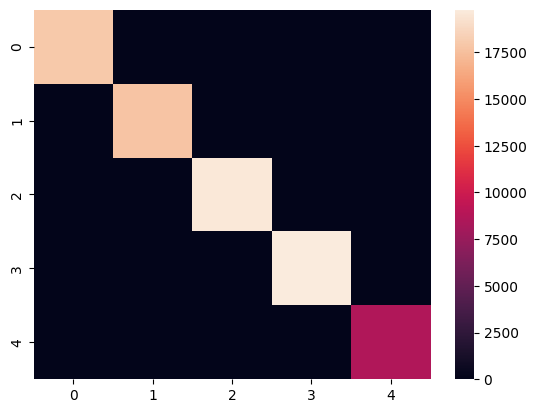

In [63]:
sns.heatmap(confusion_matrix(y_test, y_pred_ts))

По матрице ошибок видно, что модель ошибается в основном присваивая близкий к правильному класс.

Хуже всего у моодели получается отличать 3 и 4 классы, а 1 и 5 модель определяет более менее стабильно.


In [67]:
def y_downsampling(model_predictions, dataset):
    i = 0
    y_pred = []
    for id in dataset.id.unique():
        mean_y = np.mean( model_predictions[i:i+id_len[id]]) # обработать выход за границу
        y_pred = np.append(y_pred, round(mean_y))
        i+=id_len[id]

    return y_pred

In [68]:
metrics(y_downsampling(y_test, X_test), y_downsampling(y_pred_ts, X_test))

KeyError: 'id'

# Сравнение результатов

In [69]:
discription = "эмб21, ДилсВсе, ПСАотд, Апрокс, -dl"

In [70]:
config_comparing = pd.read_csv("model_configs.csv", index_col=0)
config_comparing.loc[config_comparing.shape[0]] = [discription, *metrics_tr, *metrics_ts, *grid_search.best_params_.values()]

FileNotFoundError: [Errno 2] No such file or directory: 'model_configs.csv'

In [ ]:
pd.reset_option('display.max_colwidth', 100)
config_comparing

In [ ]:
config_comparing.to_csv("model_configs.csv")

# Мусорка

In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred_ts)
score

In [ ]:
tables_counter = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        tables_counter.append(os.path.exists(deals_1) + os.path.exists(deals_2) + os.path.exists(deals_3))
tables_counter.count(0)

In [ ]:
pd.Series(tables_counter).hist()

In [ ]:
tables_exists = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        if os.path.exists(deals_1):
            tables_exists.append(1)
        if os.path.exists(deals_2):
            tables_exists.append(2)
        if os.path.exists(deals_3):
            tables_exists.append(3)
pd.Series(tables_exists).hist()

In [ ]:
len_deals_1 = []
len_deals_2 = []
len_deals_3 = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        if os.path.exists(deals_1):
            len_deals_1.append(len(pd.read_csv(deals_1)))
        if os.path.exists(deals_2):
            len_deals_2.append(len(pd.read_csv(deals_2)))
        if os.path.exists(deals_3):
            len_deals_3.append(len(pd.read_csv(deals_3)))

In [ ]:
print(len(set(len_deals_1)), len([len_deals_1.count(i) for i in set(len_deals_1)]))

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize = (18, 8))
axes.plot(list(set(len_deals_1)), [len_deals_1.count(i) for i in set(len_deals_1)])
axes.plot(list(set(len_deals_2)), [len_deals_2.count(i) for i in set(len_deals_2)])
axes.plot(list(set(len_deals_3)), [len_deals_3.count(i) for i in set(len_deals_3)])
axes.set_xlabel("длина", fontsize = 16)
axes.set_ylabel("частота", fontsize = 16)
axes.legend(fontsize = 14)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_ts)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.scatter(adding_embedings(train)[0], adding_embedings(train)[1], [1])


In [ ]:
d_pca=[1, 2, 3, 4, 5, 6, 7, 8, 9]
fix_size = 4
[d_pca[i*(len(d_pca)//(fix_size-1)) if i!=fix_size-1 else -1] for i in range(fix_size)]

In [ ]:
account_condition.exist()

In [ ]:
a = w = i = 9
w+i

In [ ]:
test_additional_info_id_account_condition_list = []
test_additional_info_id_reference_point_list = []
test_additional_info_id_stats_table_list = []
test_deals_list = []

account_condition_list = []
reference_point_list = []
stats_table_list = []
test_deals_list = []
list_cnt_tables = []

main = pd.read_csv(f'/content/data/test/test.csv', sep = ',')
ids = main['id']

cnt_tables = 0
for id in ids:
    test_additional_info_id_account_condition_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv'))
    test_additional_info_id_reference_point_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv'))
    test_additional_info_id_stats_table_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv', sep=';'))
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv').empty):
        account_condition_list.append(1)
        cnt_tables += 1
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv').empty):
        reference_point_list.append(1)
        cnt_tables += 1
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv').empty):
        test_deals_list.append(1)
        cnt_tables += 1
    list_cnt_tables.append(cnt_tables)
    cnt_tables = 0

test_additional_info_id_account_condition = pd.concat(test_additional_info_id_account_condition_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_reference_point = pd.concat(test_additional_info_id_reference_point_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_stats_table = pd.concat(test_additional_info_id_stats_table_list, axis=0, join='outer', ignore_index=False, keys=ids)

# for id in ids:
#   test_deals_list.append(pd.read_csv(f'/content/data/test/test_deals/1_{id}.csv'))
# test_deals = pd.concat(test_deals_list, axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids, 
                             'count_tables' : list_cnt_tables, 
                             })

distr_tables  

In [ ]:
test_additional_info_id_account_condition_list = []
test_additional_info_id_reference_point_list = []
test_additional_info_id_stats_table_list = []
test_deals_list = []

account_condition_list = []
reference_point_list = []
stats_table_list = []
test_deals_list = []
list_cnt_tables = []

main = pd.read_csv(f'/content/data/test/test.csv', sep = ',')
ids = main['id']

cnt_tables = 0
for id in ids:
  test_additional_info_id_account_condition_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv'))
  test_additional_info_id_reference_point_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv'))
  test_additional_info_id_stats_table_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv', sep=';'))
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv').empty):
    account_condition_list.append(1)
    cnt_tables += 1
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv').empty):
    reference_point_list.append(1)
    cnt_tables += 1
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv').empty):
    test_deals_list.append(1)
    cnt_tables += 1
  list_cnt_tables.append(cnt_tables)
  cnt_tables = 0

test_additional_info_id_account_condition = pd.concat(test_additional_info_id_account_condition_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_reference_point = pd.concat(test_additional_info_id_reference_point_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_stats_table = pd.concat(test_additional_info_id_stats_table_list, axis=0, join='outer', ignore_index=False, keys=ids)

# for id in ids:
#   test_deals_list.append(pd.read_csv(f'/content/data/test/test_deals/1_{id}.csv'))
# test_deals = pd.concat(test_deals_list, axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids, 
                             'count_tables' : list_cnt_tables, 
                             })

distr_tables

In [ ]:
test_additional_info_id_account_condition.head()

In [ ]:
# много пропусков
test_additional_info_id_account_condition.info()

In [ ]:
# много пропусков
test_additional_info_id_reference_point.info()

In [ ]:
# много пропусков
test_additional_info_id_stats_table.info()

In [ ]:
test_additional_info_id_account_condition.sum(level='id')